In [1]:
from generate_ftw_rom import get_ftws
from generate_waveform_rom import get_waveform_rom
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fftpack import fft

clock_frequency = 1e8
sampling_frequency = 48828
pwm_frequency = clock_frequency
phase_update_freq = clock_frequency
phase_bits = 32
address_bits = 17
sample_bits = 11
amplitude = 0.4

ftws = get_ftws(phase_bits, pwm_frequency)
waveform_rom = get_waveform_rom(address_bits, sample_bits)

In [2]:
# uses global params
def to_signed(value, bits):
    if value >= 2**(bits-1):
        return value - 2**bits
    return value
    
def dds_generate_output(note_number, sampling_frequency, total_time):
    phase_register = 0
    ftw = ftws[note_number]
    
    values = []
    phase_updates_per_sample = int(phase_update_freq/sampling_frequency)
    total_steps = int(total_time*phase_update_freq)
    for i in range(0, total_steps):
        if i % phase_updates_per_sample == 0:
            address = phase_register // 2 ** (phase_bits-address_bits)
            values.append(to_signed(waveform_rom[address], sample_bits))
        phase_register = (phase_register + ftw) % 2**phase_bits

    ts = np.arange(0, total_time, 1/sampling_frequency)
    lmin = min(len(ts), len(values))
    return ts[:lmin], values[:lmin]

In [3]:
def note_number_to_freq(note_number):
    s = 2**(1/12)
    return 440 * s**(note_number-69)

def plot_dds_output(note_number, sampling_frequency, total_time=None):
    if total_time is None:
        freq = note_number_to_freq(note_number)
        total_time = 1/freq * 3
    ts, ys = dds_generate_output(note_number, sampling_frequency, total_time)
    no_dds = amplitude * np.sin(2*np.pi*freq * ts) * 2**(sample_bits-1)
    plt.plot(ts, ys, ts, no_dds)

def get_dds_snr(note_number):
    freq = note_number_to_freq(note_number)
    total_time = 1/freq * 3 # three periods
    ts, ys = dds_generate_output(note_number, sampling_frequency, total_time)
    no_dds = 0.4 * np.sin(2*np.pi*freq * ts) * 2**(sample_bits-1)
    dds_error = ys - no_dds
    signal_power = sum(no_dds**2)/len(no_dds)
    error_power = sum(dds_error ** 2)/len(dds_error)
    return signal_power/error_power

In [4]:
snrs = [get_dds_snr(i) for i in range(50, 127)]

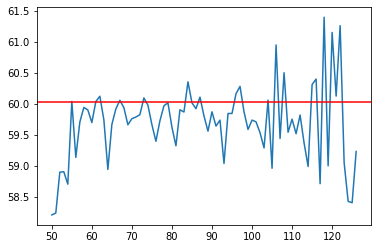

In [5]:
plt.plot(list(range(50, 127)), 10 * np.log10(snrs))
signal_power = (amplitude * 2**(sample_bits-1))**2/2
plt.axhline(10*np.log10(signal_power * 12), color='r')

In [6]:
# note_frequencies vs ftw in Hz
ftw_in_hz = [ftw/2**phase_bits * clock_frequency for ftw in ftws]
freqs = [note_number_to_freq(i) for i in range(0, 128)]
rng = list(range(0, len(ftws)))

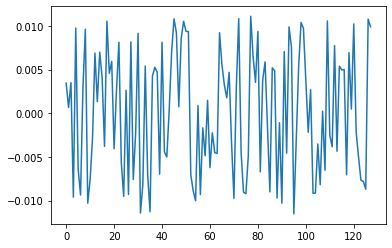

In [7]:
plt.plot(rng, [x-y for x, y in zip(freqs,ftw_in_hz)])

In [8]:
def get_pwm_signal(signal, pwm_frequency, sample_frequency):
    total_time = len(signal)/sample_frequency
    ts = np.arange(0, total_time, 1/pwm_frequency)
    pwm_pulses = int(pwm_frequency/sample_frequency)

    pwm_data = []
    max_range = amplitude * 2**(sample_bits - 1)
    for sample in signal:
        num_positive_pulses = (pwm_pulses + int(sample/max_range * pwm_pulses)) // 2
        pwm_data.extend([max_range] * num_positive_pulses)
        pwm_data.extend([-max_range] * (pwm_pulses - num_positive_pulses))
    return ts, pwm_data

def get_filtered_signal(y, pwm_frequency, cutoff_frequency=15000):
    b, a = signal.butter(4, cutoff_frequency/(pwm_frequency/2), 'low')
    return signal.lfilter(b, a, y)

In [36]:
note_number = 100
ts, dds_signal = dds_generate_output(note_number, sampling_frequency, 1000 * 1/note_number_to_freq(note_number))

In [34]:
tsp, pwm_signal = get_pwm_signal(dds_signal, clock_frequency, sampling_frequency)
filtered_signal = get_filtered_signal(pwm_signal, pwm_frequency)

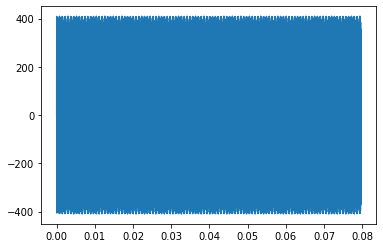

In [32]:
lmin = min(len(ts), len(dds_signal))
plt.plot(ts[:lmin], dds_signal[:lmin])
#lmin = min(len(tsp), len(pwm_signal))
#plt.plot(tsp[:lmin], pwm_signal[:lmin])
#lmin = min(len(tsp), len(filtered_signal))
#plt.plot(tsp[:lmin], filtered_signal[:lmin])

In [17]:
def get_real_scaled_fft(signal):
    signal_fft = fft(signal - np.mean(signal))
    FFT = np.abs(signal_fft)/len(signal)
    Y = FFT[0:len(signal)//2]
    Y[1:] = 2 * Y[1:]
    return Y

def plot_fft(signal, sampling_frequency, max_freq=21000):
    L = len(signal)
    Y = get_real_scaled_fft(signal)
    fs = pwm_frequency/L * np.arange(0, L/2)
    max_len = int(np.round(max_freq / sampling_frequency * L))
    max_len = min(max_len, len(fs), len(Y))
    plt.plot(fs[:max_len], Y[:max_len])

In [ ]:
plot_fft(filtered_signal, pwm_frequency, 1000)
plt.axvline(note_number_to_freq(note_number), color='r')